# Estimating Stellar Mass-to-Light Ratios using Colours

Based on the work by [Taylor et al. (2011)](https://academic.oup.com/mnras/article/418/3/1587/1060932) and maybe [Gallazzi & Bell (2009)](https://iopscience.iop.org/article/10.1088/0067-0049/185/2/253)


In [1]:
# May need to do this if running remote server with VS Code
%cd "/arc/home/IsaacCheng/coop_f2021/warmup"

/arc/home/IsaacCheng/coop_f2021/warmup


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from astropy.wcs import WCS
import astropy.units as u
import fits_plot_utils as utils
import dill
from scipy.optimize import curve_fit
from scipy.stats import spearmanr, pearsonr
import scipy.odr as odr
from astropy.wcs.utils import proj_plane_pixel_scales, skycoord_to_pixel

# Load and mask data


In [3]:
# 
# Load binned data from pickle file
# 
g_infile = "/arc/home/IsaacCheng/coop_f2021/binned_data/NGVS-2-2.l.g.Mg004.3136_8588_6905_10184_BINNED_MAGS_reproject_exact+masked_star.pkl"
with open(g_infile, "rb") as f:
    g_file = dill.load(f)
    vcc792_dist_pc = g_file["dist_pc"]
    vcc792_dist_err_pc = g_file["dist_pc_err"]
    g_xs = g_file["x_coords"]
    g_ys = g_file["y_coords"]
    g_signal = g_file["signal_binned"]
    g_noise = g_file["noise_binned"]
    g_abs_mag = g_file["abs_mag"]
    g_abs_mag_err = g_file["abs_mag_err"]
    g_isgood = g_file["is_good"]
    g_wcs = g_file["wcs_binned"]
    g_wcs.array_shape = g_file["wcs_binned_array_shape"]
# 
i_infile = "/arc/home/IsaacCheng/coop_f2021/binned_data/NGVS-2-2.l.i.Mg004.3136_8588_6905_10184_BINNED_MAGS_reproject_exact+masked_star.pkl"
with open(i_infile, "rb") as f:
    i_file = dill.load(f)
    i_xs = i_file["x_coords"]
    i_ys = i_file["y_coords"]
    i_signal = i_file["signal_binned"]
    i_noise = i_file["noise_binned"]
    i_abs_mag = i_file["abs_mag"]
    i_abs_mag_err = i_file["abs_mag_err"]
    i_isgood = i_file["is_good"]
    i_wcs = i_file["wcs_binned"]
    i_wcs.array_shape = i_file["wcs_binned_array_shape"]
# 
# Load CO map data
# 
co_path = "/arc/projects/vertico/products/release.v1.2/nyquistPix/9arcsec/NGC4380/NGC4380_7m+tp_co21_pbcorr_round_k_nyquistPix_9_arcsec_mom0_Msun.fits"
data_co, header_co = utils.load_img(co_path)
wcs_co = WCS(header_co)

Filename: /arc/projects/vertico/products/release.v1.2/nyquistPix/9arcsec/NGC4380/NGC4380_7m+tp_co21_pbcorr_round_k_nyquistPix_9_arcsec_mom0_Msun.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      63   (42, 42)   float64   


In [4]:
gi_signal = -2.5 * np.log10(g_signal / i_signal)  # g- & i-values from binned data
gi_noise = utils.calc_colour_err(g_signal, i_signal, g_noise, i_noise)
# 
def calc_pixel_size(imgwcs, dist, dist_err=None):
    """
    Calculates the physical size of each pixel in parsecs per pixel dimension.
    
    Parameters:
      imgwcs :: `astropy.wcs.wcs.WCS`
        The WCS coordinates of the .fits file
      dist :: `astropy.units.quantity.Quantity` scalar 
        The distance to the object
      dist_err :: `astropy.units.quantity.Quantity` scalar (optional, default: None)
        The uncertainty in the distance to the object

    Returns: pc_per_px, pc_per_px_err
      pc_per_px :: some astropy quantity
        The spatial resolution of the image in parsecs per pixel (along each axis)
      pc_per_px_err :: some astropy quantity
        The uncertainty in the spatial resolution of the image (along each axis)
    """
    arcsec_per_px = (proj_plane_pixel_scales(imgwcs.celestial) * u.deg).to(u.arcsec)
    # Still deciding whether to use arctan for the next line
    arcsec_per_pc = np.rad2deg(1 * u.pc / dist.to(u.pc) * u.rad).to(u.arcsec)
    pc_per_px = arcsec_per_px / arcsec_per_pc
    # 
    if dist_err is not None:
        # arcsec_per_pc_err = np.rad2deg(1 * u.pc / dist_err.to(u.pc) * u.rad).to(u.arcsec)
        # pc_per_px_err = arcsec_per_px / arcsec_per_pc_err
        # Uncertainty transforms linearly
        pc_per_px_err = pc_per_px * dist_err.to(u.pc) / dist.to(u.pc)
        return pc_per_px, pc_per_px_err
    return pc_per_px, None
#
# Get absolute magnitudes in i-band
#
abs_mag_i, abs_mag_i_err = utils.calc_mag(
    i_signal,
    i_noise,
    zpt=30,
    calc_abs=True,
    dist=vcc792_dist_pc,
    dist_err=vcc792_dist_err_pc,
)
# abs_mag_i = rel_mag_i - 5 * (np.log10(vcc792_dist_pc) - 1)
abs_mag_i_sun = 4.58  # absolute AB magnitude of Sun in i-band
#
# Eq. (7) of Taylor et al. (2011)
#
log_MLi = -0.68 + 0.70 * gi_signal  # log10 of mass-to-light ratio in i-band
log_MLi_err = 0.7 * gi_noise  # uncertainty in log10 of mass-to-light ratio
MLi = 10 ** log_MLi  # mass-to-light ratio in i-band
MLi_err = np.log(10) * abs(MLi * log_MLi_err)  # uncertainty in mass-to-light ratio
#
# Get masses in solar units
#
Li = 10 ** (-0.4 * (abs_mag_i - abs_mag_i_sun))  # luminosity in i-band
Li_err = abs(
    Li * np.log(10) * 0.4 * abs_mag_i_err
)  # uncertainty in luminosity, assuming no error in abs_mag_i_sun
M = MLi * Li  # masses in solar units
M_err = np.sqrt((MLi_err / MLi) ** 2 + (Li_err / Li) ** 2) * M  # uncertainty in masses
# 
# Get mass densities
# 
i_pc_per_px, i_pc_per_px_err = calc_pixel_size(i_wcs, vcc792_dist_pc * u.pc, vcc792_dist_err_pc * u.pc)
print(i_pc_per_px, i_pc_per_px_err)
px_area = i_pc_per_px[0] * i_pc_per_px[1]  # pixel area in pc^2
px_area_err = (
    np.sqrt(
        (i_pc_per_px_err[0] / i_pc_per_px[0]) ** 2
        + (i_pc_per_px_err[1] / i_pc_per_px[1]) ** 2
    )
    * px_area
)  # uncertainty in pixel area
print(px_area, px_area_err, px_area_err / px_area)
M_density = M / px_area  # stellar mass density in solar units per parsec^2
M_density_err = np.sqrt((M_err / M) ** 2 + (px_area_err / px_area) ** 2) * M_density
#
# Save to file
#
Li_outfile = "/arc/home/IsaacCheng/coop_f2021/binned_data/vcc792_MLi_BINNED_reproject_exact+masked_star.txt"
id_arr = np.array(
    [str(x).zfill(2) + str(y).zfill(2) for x, y in zip(g_xs.flatten(), g_ys.flatten())]
)
Li_outdata = pd.DataFrame(
    {
        "id": id_arr,
        "M": M.flatten(),
        "M_err": M_err.flatten(),
        "Li": Li.flatten(),
        "Li_err": Li_err.flatten(),
        "MLi": MLi.flatten(),
        "MLi_err": MLi_err.flatten(),
        "M_density": M_density.flatten(),
        "M_density_err": M_density_err.flatten(),
    }
)
# Li_outdata.to_csv(Li_outfile, sep=" ", index=False, header=True)
#
# Calculating masses using Eq. (8) of Taylor et al. (2011)
#
# M2 = 10 ** (1.15 + 0.7 * gi_signal - 0.4 * abs_mag_i)
# print(M)
# print(M2)


[446.02858662 446.02858662] [44.60285866 44.60285866]
198941.5000828847 28134.576753606376 0.1414213562373095


# Stellar Mass Map & Mass-to-Light Ratio Map


In [7]:
%matplotlib widget
plt.close("all")
# 
# Plot mass map
# 
cmap = "viridis"
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 4.5), subplot_kw={"projection": i_wcs})
img1 = ax1.imshow(M, cmap=cmap, norm=LogNorm(vmin=2e6, vmax=1e8))
# img = ax1.imshow(M, cmap=cmap, vmin=1e6, vmax=3e7)
# img = ax1.imshow(M, cmap=cmap, vmin=1e6, vmax=5e7)
cbar1 = fig.colorbar(img1, ax=ax1, fraction=0.046)
cbar1.ax.tick_params(which="both", direction="out")
cbar1.set_label(r"Stellar Mass ($\rm M_*/M_\odot$)")
cbar1.ax.yaxis.set_offset_position("left")
ax1.contour(
    data_co,
    transform=ax1.get_transform(WCS(header_co)),
    levels=range(0, 15, 5),
    colors="w"
)
ax1.set_title("Stellar Mass Map Estimate")
ax1.set_xlabel("RA (J2000)")
ax1.set_ylabel("Dec (J2000)")
ax1.grid(False)
ax1.set_aspect("equal")
# 
img2 = ax2.imshow(MLi, cmap=cmap, vmax=1.5)
cbar2 = fig.colorbar(img2, ax=ax2, fraction=0.046)
cbar2.ax.tick_params(which="both", direction="out")
cbar2.set_label(r"Mass-to-Light Ratio")
cbar2.ax.yaxis.set_offset_position("left")
ax2.contour(
    data_co,
    transform=ax2.get_transform(WCS(header_co)),
    levels=range(0, 15, 5),
    colors="w"
)
ax2.set_title("Mass-to-Light Ratio Estimate")
ax2.set_xlabel("RA (J2000)")
ax2.set_ylabel("Dec (J2000)")
ax2.grid(False)
ax2.set_aspect("equal")
# 
fig.tight_layout(pad=5)
fig.suptitle("VCC 792 / NGC 4380")
# fig.savefig("imgs/vcc792_i-mass_estimate+ML_ratio+masked_star.pdf")
plt.show()


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

# Stellar Mass vs. CO Density


[0.06275764 6.61632243] [0.05034127 0.36156839]
R^2: 0.375125400264835


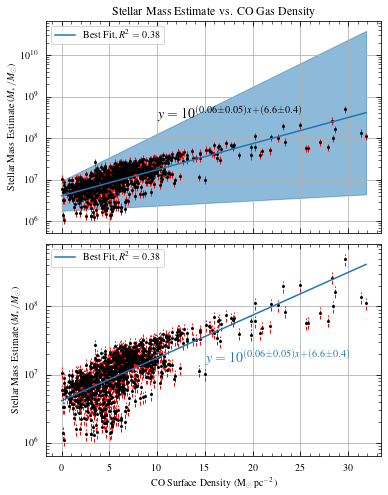

In [153]:
%matplotlib inline
plt.close("all")
#
# Plot stellar mass vs CO density
#
def line(x, m, b):
    return m * x + b
#
# Nonlinear least squares regression
#
popt, pcov = curve_fit(
    line,
    data_co[data_co > 0],
    np.log10(M[data_co > 0]),
    sigma=np.log10(M_err[data_co > 0]),
    absolute_sigma=True,
)
pstd = np.sqrt(np.diag(pcov))
xvals = np.linspace(0, np.max(data_co), 100)
print(popt, pstd)
# 
# Calculate coefficient of determination
# 
sum_sq_res = np.sum((10 ** line(data_co[data_co > 0], *popt) - M[data_co > 0]) ** 2)
tot_sum_sq = np.sum((M[data_co > 0] - np.mean(M[data_co > 0])) ** 2)
r_sq = 1 - sum_sq_res / tot_sum_sq
print("R^2:", r_sq)
#
# Plot
#
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(6, 8), sharex=True)
ebar1 = ax1.errorbar(
    x=data_co[data_co > 0],
    y=M[data_co > 0],
    yerr=M_err[data_co > 0],
    fmt=".",
    markersize=4,
    color="k",
    ecolor="r",
    elinewidth=1,
)
ebar1[-1][0].set_linestyle("--")
ax1.plot(xvals, 10 ** line(xvals, *popt), c="tab:blue", label=f"Best Fit, $R^2={r_sq:.2f}$", zorder=10)
ax1.fill_between(
    xvals,
    10 ** line(xvals, *(popt - pstd)),
    10 ** line(xvals, *(popt + pstd)),
    alpha=0.5,
    color="tab:blue",
)
ax1.text(
    10,
    3e8,
    f"$y=10^{{({popt[0]:.2f} \\pm {pstd[0]:.2f})x + ({popt[1]:.1f} \\pm {pstd[1]:.1f})}}$",
    color="k",
    fontsize=14,
)
ax1.set_yscale("log")
ax1.set_ylabel(r"Stellar Mass Estimate ($M_*/M_\odot$)")
ax1.set_title("Stellar Mass Estimate vs. CO Gas Density")
ax1.legend(loc="upper left")
# Plot without shaded errors
ebar2 = ax2.errorbar(
    x=data_co[data_co > 0],
    y=M[data_co > 0],
    yerr=M_err[data_co > 0],
    fmt=".",
    markersize=4,
    color="k",
    ecolor="r",
    elinewidth=1,
)
ebar2[-1][0].set_linestyle("--")
ax2.plot(xvals, 10 ** line(xvals, *popt), c="tab:blue", label=f"Best Fit, $R^2={r_sq:.2f}$", zorder=10)
ax2.text(
    15,
    1.5e7,
    f"$y=10^{{({popt[0]:.2f} \\pm {pstd[0]:.2f})x + ({popt[1]:.1f} \\pm {pstd[1]:.1f})}}$",
    color="tab:blue",
    fontsize=14,
)
ax2.set_yscale("log")
ax2.set_xlabel(r"CO Surface Density ($\rm M_\odot\; pc^{-2}$)")
ax2.set_ylabel(r"Stellar Mass Estimate ($M_*/M_\odot$)")
# ax2.set_title("Stellar Mass Estimate vs. CO Gas Density")
ax2.legend(loc="upper left")
plt.subplots_adjust(hspace=0.05)
# fig.savefig("imgs/vcc792_i-mass_vs_CO.pdf")
plt.show()

# CO Density vs. Stellar Mass Density (Molecular Gas Main Sequence)


[ 8.85783174 -9.04082524] [0.25932562 0.45858903]
R^2: 0.5409681061271687
SpearmanrResult(correlation=0.7223658280729667, pvalue=8.83127744200133e-161)
(0.7355053406516969, 1.4101743123278473e-169)


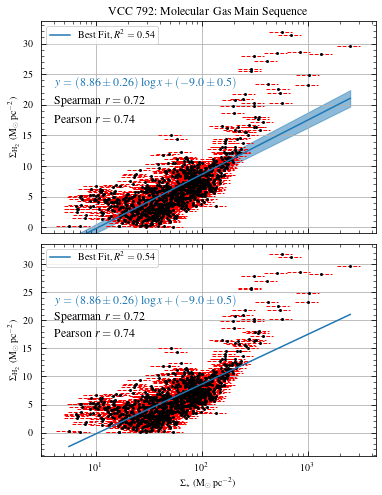

In [31]:
%matplotlib inline
plt.close("all")
#
# Plot CO density vs stellar mass density
#
def line(x, m, b):
    return m * x + b
#
# Nonlinear least squares regression
#
popt, pcov = curve_fit(
    line,
    np.log10(M_density[data_co > 0]),
    data_co[data_co > 0],
    # sigma=np.log10(M_density_err[data_co > 0]),
    # absolute_sigma=True,
)
pstd = np.sqrt(np.diag(pcov))
xvals = np.linspace(
    np.log10(M_density[data_co > 0].min()),
    np.log10(M_density[data_co > 0].max()),
    100
)
print(popt, pstd)
# 
# Calculate coefficient of determination
# 
sum_sq_res = np.sum((line(np.log10(M_density[data_co > 0]), *popt) - data_co[data_co > 0]) ** 2)
tot_sum_sq = np.sum((data_co[data_co > 0] - np.mean(data_co[data_co > 0])) ** 2)
r_sq = 1 - sum_sq_res / tot_sum_sq
print("R^2:", r_sq)
# 
# Calculate Spearman correlation coefficient
# 
spearman_corr = spearmanr(M_density[data_co > 0], data_co[data_co > 0])
print(spearman_corr)
pearson_corr = pearsonr(np.log10(M_density[data_co > 0]), data_co[data_co > 0])
print(pearson_corr)
#
# Plot
#
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(6, 8), sharex=True)
ebar1 = ax1.errorbar(
    x=M_density[data_co > 0],
    y=data_co[data_co > 0],
    xerr=M_density_err[data_co > 0],
    fmt=".",
    markersize=4,
    color="k",
    ecolor="r",
    elinewidth=1,
)
ebar1[-1][0].set_linestyle("--")
ax1.plot(10 ** xvals, line(xvals, *popt), c="tab:blue", label=f"Best Fit, $R^2={r_sq:.2f}$", zorder=10)
ax1.fill_between(
    10 ** xvals,
    line(xvals, *(popt - pstd)),
    line(xvals, *(popt + pstd)),
    alpha=0.5,
    color="tab:blue",
)
ax1.text(
    4,
    23,
    f"$y={{({popt[0]:.2f} \\pm {pstd[0]:.2f})\log x + ({popt[1]:.1f} \\pm {pstd[1]:.1f})}}$",
    color="tab:blue",
    fontsize=12,
)
ax1.text(
    4,
    20,
    f"Spearman $r={spearman_corr[0]:.2f}$",
    color="k",
    fontsize=12,
)
ax1.text(
    4,
    17,
    f"Pearson $r={pearson_corr[0]:.2f}$",
    color="k",
    fontsize=12,
)
ax1.set_xscale("log")
ax1.set_ylim(bottom=-1)
ax1.set_ylabel(r"$\rm \Sigma_{H_2}$ ($\rm M_\odot\; pc^{-2}$)")
ax1.set_title("VCC 792: Molecular Gas Main Sequence")
ax1.legend(loc="upper left")
# Plot without shaded errors
ebar2 = ax2.errorbar(
    x=M_density[data_co > 0],
    y=data_co[data_co > 0],
    xerr=M_density_err[data_co > 0],
    fmt=".",
    markersize=4,
    color="k",
    ecolor="r",
    elinewidth=1,
)
ebar2[-1][0].set_linestyle("--")
ax2.plot(10 ** xvals, line(xvals, *popt), c="tab:blue", label=f"Best Fit, $R^2={r_sq:.2f}$", zorder=10)
ax2.text(
    4,
    23,
    f"$y={{({popt[0]:.2f} \\pm {pstd[0]:.2f})\log x + ({popt[1]:.1f} \\pm {pstd[1]:.1f})}}$",
    color="tab:blue",
    fontsize=12,
)
ax2.text(
    4,
    20,
    f"Spearman $r={spearman_corr[0]:.2f}$",
    color="k",
    fontsize=12,
)
ax2.text(
    4,
    17,
    f"Pearson $r={pearson_corr[0]:.2f}$",
    color="k",
    fontsize=12,
)
ax2.set_xscale("log")
ax2.set_ylabel(r"$\rm \Sigma_{H_2}$ ($\rm M_\odot\; pc^{-2}$)")
ax2.set_xlabel(r"$\rm \Sigma_{\star}$ ($\rm M_\odot\; pc^{-2}$)")
# ax2.set_title("Stellar Mass Estimate vs. CO Gas Density")
ax2.legend(loc="upper left")
plt.subplots_adjust(hspace=0.05)
# fig.savefig("imgs/vcc792_MGMS.pdf")
plt.show()

Beta: [ 9.79061856 -8.78528673]
Beta Std Error: [0.34761457 0.48149276]
Beta Covariance: [[ 0.79180668 -1.07094193]
 [-1.07094193  1.51915732]]
Residual Variance: 0.1526078141428601
Inverse Condition #: 0.014755032230841725
Reason(s) for Halting:
  Parameter convergence
[ 9.79061856 -8.78528673]
[0.8898352 1.232541 ]
[ 9.79061856 -8.78528673] [0.8898352 1.232541 ]
R^2: 0.3425585298415379
SpearmanrResult(correlation=0.7223658280729667, pvalue=8.83127744200133e-161)
(0.7355053406516969, 1.4101743123278473e-169)


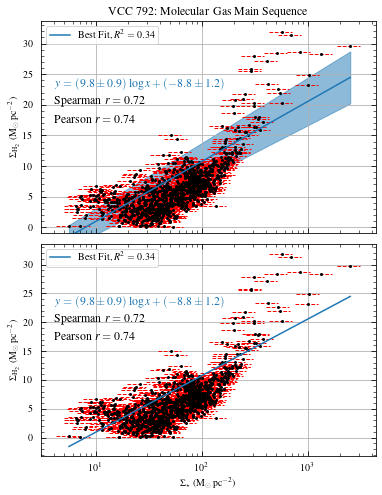

In [45]:
%matplotlib inline
plt.close("all")
#
# Plot CO density vs stellar mass density USING ODR
#
def line_odr(params, x):
    return params[0] * x + params[1]
#
# Orthogonal distance regression
#
popt, pcov = curve_fit(
    line,
    np.log10(M_density[data_co > 0]),
    data_co[data_co > 0],
    # sigma=np.log10(M_density_err[data_co > 0]),
    # absolute_sigma=True,
)
# Create model for fitting
model = odr.Model(line_odr)
# RealData object
model_data = odr.RealData(
    x=np.log10(M_density[data_co > 0]),
    y=data_co[data_co > 0],
    sx=np.log10(M_density_err[data_co > 0]),
    # sx=M_density_err[data_co > 0] / M_density[data_co > 0] / np.log(10),
    sy=np.full_like(data_co[data_co > 0], 1e-12),  # assign very small, non-zero error
)
# Set up ODR with model and data
my_odr = odr.ODR(model_data, model, beta0=[10, 0])
# Run regression
my_output = my_odr.run()
# Print results
my_output.pprint()
# Get optimal parameters
popt = my_output.beta
pstd = np.sqrt(np.diag(my_output.cov_beta))
print(popt)
print(pstd)
# 
xvals = np.linspace(
    np.log10(M_density[data_co > 0].min()),
    np.log10(M_density[data_co > 0].max()),
    100
)
print(popt, pstd)
# 
# Calculate coefficient of determination
# 
sum_sq_res = np.sum((line(np.log10(M_density[data_co > 0]), *popt) - data_co[data_co > 0]) ** 2)
tot_sum_sq = np.sum((data_co[data_co > 0] - np.mean(data_co[data_co > 0])) ** 2)
r_sq = 1 - sum_sq_res / tot_sum_sq
print("R^2:", r_sq)
# 
# Calculate Spearman correlation coefficient
# 
spearman_corr = spearmanr(M_density[data_co > 0], data_co[data_co > 0])
print(spearman_corr)
pearson_corr = pearsonr(np.log10(M_density[data_co > 0]), data_co[data_co > 0])
print(pearson_corr)
#
# Plot
#
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(6, 8), sharex=True)
ebar1 = ax1.errorbar(
    x=M_density[data_co > 0],
    y=data_co[data_co > 0],
    xerr=M_density_err[data_co > 0],
    fmt=".",
    markersize=4,
    color="k",
    ecolor="r",
    elinewidth=1,
)
ebar1[-1][0].set_linestyle("--")
ax1.plot(10 ** xvals, line_odr(popt, xvals), c="tab:blue", label=f"Best Fit, $R^2={r_sq:.2f}$", zorder=10)
ax1.fill_between(
    10 ** xvals,
    line_odr((popt - pstd), xvals),
    line_odr((popt + pstd), xvals),
    alpha=0.5,
    color="tab:blue",
)
ax1.text(
    4,
    23,
    f"$y={{({popt[0]:.1f} \\pm {pstd[0]:.1f})\log x + ({popt[1]:.1f} \\pm {pstd[1]:.1f})}}$",
    color="tab:blue",
    fontsize=12,
)
ax1.text(
    4,
    20,
    f"Spearman $r={spearman_corr[0]:.2f}$",
    color="k",
    fontsize=12,
)
ax1.text(
    4,
    17,
    f"Pearson $r={pearson_corr[0]:.2f}$",
    color="k",
    fontsize=12,
)
ax1.set_xscale("log")
ax1.set_ylim(bottom=-1)
ax1.set_ylabel(r"$\rm \Sigma_{H_2}$ ($\rm M_\odot\; pc^{-2}$)")
ax1.set_title("VCC 792: Molecular Gas Main Sequence")
ax1.legend(loc="upper left")
# Plot without shaded errors
ebar2 = ax2.errorbar(
    x=M_density[data_co > 0],
    y=data_co[data_co > 0],
    xerr=M_density_err[data_co > 0],
    fmt=".",
    markersize=4,
    color="k",
    ecolor="r",
    elinewidth=1,
)
ebar2[-1][0].set_linestyle("--")
ax2.plot(10 ** xvals, line_odr(popt, xvals), c="tab:blue", label=f"Best Fit, $R^2={r_sq:.2f}$", zorder=10)
ax2.text(
    4,
    23,
    f"$y={{({popt[0]:.1f} \\pm {pstd[0]:.1f})\log x + ({popt[1]:.1f} \\pm {pstd[1]:.1f})}}$",
    color="tab:blue",
    fontsize=12,
)
ax2.text(
    4,
    20,
    f"Spearman $r={spearman_corr[0]:.2f}$",
    color="k",
    fontsize=12,
)
ax2.text(
    4,
    17,
    f"Pearson $r={pearson_corr[0]:.2f}$",
    color="k",
    fontsize=12,
)
ax2.set_xscale("log")
ax2.set_ylabel(r"$\rm \Sigma_{H_2}$ ($\rm M_\odot\; pc^{-2}$)")
ax2.set_xlabel(r"$\rm \Sigma_{\star}$ ($\rm M_\odot\; pc^{-2}$)")
# ax2.set_title("Stellar Mass Estimate vs. CO Gas Density")
ax2.legend(loc="upper left")
plt.subplots_adjust(hspace=0.05)
# fig.savefig("imgs/vcc792_MGMS.pdf")
plt.show()

# Gas Fraction Map


In [12]:
%matplotlib widget
plt.close("all")
# 
# Make 2D plot of stellar mass density to CO density ratio
# Q: at the same gas density, why do some pixels have higher stellar mass densities than
# others? What is the distinguishing factor?
# 
# Some data_co elements < 0...
mass_per_co = abs(M_density / data_co)  # Stellar mass density per CO surface density
fig, ax = plt.subplots(subplot_kw={"projection": i_wcs})
img = ax.imshow(mass_per_co, cmap="Blues", vmin=0, vmax=40)
cbar = fig.colorbar(img, ax=ax)
cbar.set_label(r"$\rm \Sigma_{\star} / \Sigma_{H_2}$")
ax.set_title("Ratio of Stellar Mass Density to H$_2$ Density")
ax.set_xlabel("RA (J2000)")
ax.set_ylabel("Dec (J2000)")
ax.grid(False)
ax.set_aspect("equal")
# fig.savefig("imgs/vcc792_mass_CO_ratio.pdf")
plt.show()
# 
# Make plot of gas fraction throughout galaxy
# 
# Some data_co elements < 0...
gas_frac = abs(
    np.ma.masked_where(data_co == 0, data_co)
    / np.ma.masked_where(data_co == 0, M_density)
)
fig, ax = plt.subplots(subplot_kw={"projection": i_wcs})
# img = ax.imshow(gas_frac, cmap="Blues", vmin=0, vmax=0.25)
img = ax.imshow(gas_frac, cmap="Blues", vmin=0, vmax=np.percentile(gas_frac, 98))
cbar = fig.colorbar(img, ax=ax)
cbar.set_label(r"Gas Fraction ($\rm \Sigma_{H_2} / \rm \Sigma_{\star}$)")
ax.set_title("VCC 792: Gas Fraction Map")
ax.set_xlabel("RA (J2000)")
ax.set_ylabel("Dec (J2000)")
ax.grid(False)
ax.set_aspect("equal")
# fig.savefig("imgs/vcc792_gas_frac.pdf")
plt.show()

/arc/home/IsaacCheng/.local/lib/python3.8/site-packages/astropy/units/quantity.py:486: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …